# **1) Симуляция процессов**

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm

In [ ]:
T = 1
N = 100
x0 = 10
t = np.linspace(0, T, N + 1)
delta = np.sqrt(T / N)

In [ ]:
#Эйлер

def Ornshtein_Uhlenbeck(S, mu, sigma, dt, dW):
    dS = -mu * S * dt + sigma * dW
    return dS

def CIR(S, theta1, theta2, sigma, dt, dW):
    dS = (theta1 - theta2 * S) * dt + sigma * np.sqrt(S) * dW
    return dS

def Black_Scholes(S, mu, sigma, dt, dW):
    dS = mu * S * dt + sigma * S * dW
    return dS

#Мильштейн

def Milstein_Ornshtein_Uhlenbeck(S, mu, sigma, dt, dW):
    dS = -mu * S * dt + sigma * dW
    return dS

def Milstein_CIR(S, theta1, theta2, sigma, dt, dW):
    dS = (theta1 - theta2 * S) * dt + sigma * np.sqrt(S) * dW + (sigma**2) * ((dW**2) - dt) / 4 
    return dS

def Milstein_Black_Scholes(S, mu, sigma, dt, dW):
    dS = mu * S * dt + sigma * S * dW + (sigma**2) * S * ((dW**2) - dt) / 2
    return dS

#Предиктор-корректор

def Predict_Ornshtein_Uhlenbeck(S, pS, theta, sigma, dt, dW, alpha, eta):
    baS  = -theta * S
    bapS = -theta * pS
    dS = alpha * bapS + (1-alpha) * bapS * dt + eta * sigma + (1 - eta) * sigma * dW
    return dS

def Predict_CIR(S, pS, theta1, theta2, sigma, dt, dW, alpha, eta):
    baS  = (theta1 - theta2 * S) - eta * (sigma**2) / 2 
    bapS = (theta1 - theta2 * pS) - eta * (sigma**2) / 2 
    dS = alpha * bapS + (1 - alpha) * baS * dt + eta * sigma * np.sqrt(pS) + (1 - eta) * sigma * np.sqrt(S) * dW
    return dS

def Predict_Black_Scholes(S, pS, mu, sigma, dt, dW, alpha, eta):
    baS  = mu * S - eta * (sigma**2) * S
    bapS = mu * pS - eta * (sigma**2) * pS
    dS = alpha * bapS + (1 - alpha) * baS * dt + eta * sigma * pS + (1-eta) * sigma * S * dW
    return dS

#2 Мильштейн

def M2_Ornshtein_Uhlenbeck(S, theta, sigma, dt, dW):
    dS = - theta * S * dt + sigma * dW - theta * dt * dW / 2 + (theta**2) * S * (dt**2) / 2 
    return dS

def M2_CIR(S, theta1, theta2, sigma, dt, dW):
    dS = (theta1 - theta2 * S - (sigma**2)/4) * dt + sigma * np.sqrt(S) * dW + (dW**2) * (sigma**2) / 4 \
    + dt * dW * (sigma * (theta1 - theta2 * S) / (4 * np.sqrt(S)) - theta2 * sigma * np.sqrt(S) / 2 - (sigma**3) / 4 / np.sqrt(S)) \
    - theta2 * (theta1 - theta2 * S) * (dt**2) / 2
    return dS

def M2_Black_Scholes(S, mu, sigma, dt, dW):
    dS = S * (mu - (sigma**2)/2) * dt + sigma * S * dW + (sigma**2) * S * (dW**2)\
    + dt * dW * mu * S * sigma + S * (mu**2) * (dt**2) / 2
    return dS

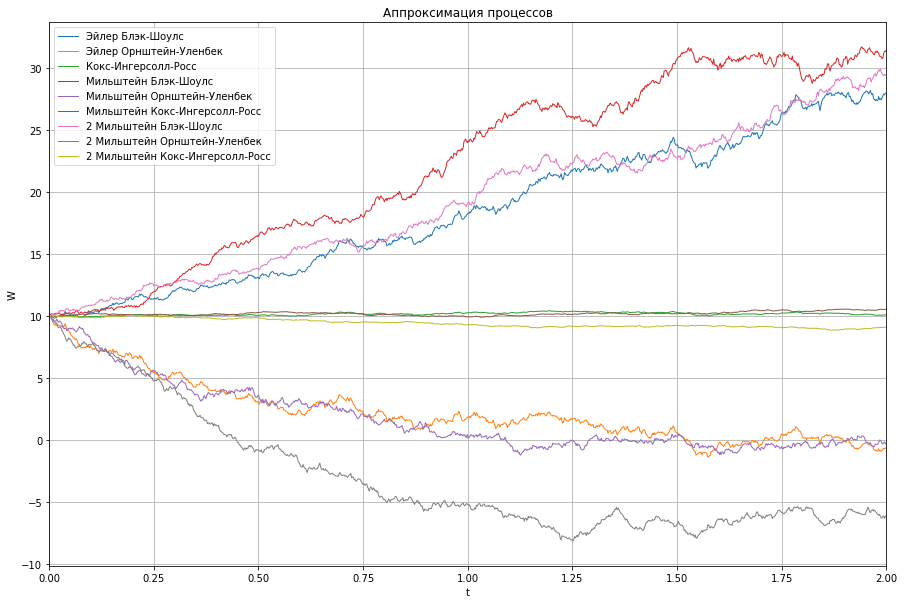

In [ ]:
def Wiener_proc(N, T):
    W = np.zeros(N)  
    delta = T / N
    sqrt_delta = np.sqrt(delta)    
    for i in range (1, N):
        W[i] += W[i-1] + np.random.normal(0, sqrt_delta)
    return W
N = 1000
W  = Wiener_proc(N, T)
dW = 0


T = 2
time_line, dt = np.linspace(0, T, N, retstep=True)
alpha = 0.33
eta   = 0.25



S_bs, S_ou, S_cir = np.zeros(N), np.zeros(N), np.zeros(N)
PS_bs, PS_ou, PS_cir = np.zeros(N), np.zeros(N), np.zeros(N)
MS_bs, MS_ou, MS_cir = np.zeros(N), np.zeros(N), np.zeros(N)
M2S_bs, M2S_ou, M2S_cir = np.zeros(N), np.zeros(N), np.zeros(N)

S_bs[0], S_ou[0], S_cir[0] = 10, 10, 10
PS_bs[0], PS_ou[0], PS_cir[0] = 10, 10, 10
MS_bs[0], MS_ou[0], MS_cir[0] = 10, 10, 10
M2S_bs[0], M2S_ou[0], M2S_cir[0] = 10, 10, 10

for i in range(1, N):
    dW = W[i] - W[i-1] 
    dt = 1/N
    # Эйлер
    S_bs[i] = S_bs[i-1] + Black_Scholes(S_bs[i-1], 1, 0.2, dt, dW)       
    S_ou[i] = S_ou[i-1] + Ornshtein_Uhlenbeck(S_ou[i-1], 5, 3.5, dt, dW)       
    S_cir[i]  = S_cir[i-1] + CIR(S_cir[i-1], 2, 0.2, 0.15, dt, dW) 
    
    # Мильштейн
    MS_bs[i] = MS_bs[i-1] + Milstein_Black_Scholes(MS_bs[i-1], 1, 0.2, dt, np.random.normal(0, np.sqrt(dt)))    
    MS_ou[i]  = MS_ou[i-1] + Milstein_Ornshtein_Uhlenbeck(MS_ou[i-1], 5, 3.5, dt, np.random.normal(0, np.sqrt(dt)))
    MS_cir[i] = MS_cir[i-1] + Milstein_CIR(MS_cir[i-1], 2, 0.2, 0.15, dt, np.random.normal(0, np.sqrt(dt)))
    
    # 2 Мильштейн
    M2S_bs[i] = M2S_bs[i-1] + M2_Black_Scholes(S_bs[i-1], 1, 0.2, dt, np.random.normal(0, np.sqrt(dt)))    
    M2S_ou[i]  = M2S_ou[i-1] + M2_Ornshtein_Uhlenbeck(S_ou[i-1], 5, 3.5, dt, np.random.normal(0, np.sqrt(dt)))
    M2S_cir[i] = M2S_cir[i-1] + M2_CIR(S_cir[i-1], 2, 0.2, 0.15, dt, np.random.normal(0, np.sqrt(dt)))
    
    # Предиктор-корректор
    PS_bs[i] = PS_bs[i-1] + Predict_Black_Scholes(PS_bs[i-1], S_bs[i], 1, 0.2, dt, np.random.normal(0, np.sqrt(dt)), alpha, eta)
    PS_ou[i]  = PS_ou[i-1] + Predict_Ornshtein_Uhlenbeck(PS_ou[i-1], S_ou[i], 5, 3.5, dt, np.random.normal(0, np.sqrt(dt)), alpha, eta)
    PS_cir[i] = PS_cir[i-1] + Predict_CIR(PS_cir[i-1], S_cir[i], 2, 0.2, 0.15, dt, np.random.normal(0, np.sqrt(dt)), alpha, eta)
    
plt.figure ( figsize =(15, 10) )
plt.grid ()
plt.plot (time_line, S_bs, linewidth =1.0, label="Эйлер Блэк-Шоулс")
plt.plot (time_line, S_ou, linewidth =1.0, label="Эйлер Орнштейн-Уленбек")
plt.plot (time_line, S_cir, linewidth =1.0, label="Кокс-Ингерсолл-Росс")
plt.plot (time_line, MS_bs, linewidth =1.0, label="Мильштейн Блэк-Шоулс")
plt.plot (time_line, MS_ou, linewidth =1.0, label="Мильштейн Орнштейн-Уленбек")
plt.plot (time_line, MS_cir, linewidth =1.0, label="Мильштейн Кокс-Ингерсолл-Росс")
plt.plot (time_line, M2S_bs, linewidth =1.0, label="2 Мильштейн Блэк-Шоулс")
plt.plot (time_line, M2S_ou, linewidth =1.0, label="2 Мильштейн Орнштейн-Уленбек")
plt.plot (time_line, M2S_cir, linewidth =1.0, label="2 Мильштейн Кокс-Ингерсолл-Росс")

plt.title ("Аппроксимация процессов")
plt.xlabel ("t")
plt.ylabel ("W")
plt.legend()
plt.xlim(0, T)
plt.show ()

# **2) Сходимость схем Эйлера и Мильштейна**

In [ ]:
def Mult_GBM(mu, sigma, t, W):
    return np.exp((mu - (sigma**2)/2)*t + sigma * W)

In [ ]:
# Data:
N = [i for i in range(100, 5100, 100)]
T = 1

mu = 1
sigma = 0.2
alpha = 0.33
eta   = 0.25

terrEU, terrM = np.zeros(len(N)), np.zeros(len(N))

j = 0

for n in N:
    W  = Wiener_proc(n, T)
    dW = 0
    time_line, dt = np.linspace(0, T, n, retstep=True)
    S_gbm, EUS_gbm, MS_gbm = np.zeros(n), np.zeros(n), np.zeros(n)
    S_gbm[0], EUS_gbm[0], MS_gbm[0] = 10, 10, 10
    for i in range(1, n):
        dW = W[i] - W[i-1]
        S_gbm[i]   = S_gbm[0] * Mult_GBM(mu, sigma, time_line[i], W[i-1])
        EUS_gbm[i] = EUS_gbm[i-1] + Black_Scholes(S_gbm[i-1], 1, 0.2, dt, dW)
        MS_gbm[i]  = MS_gbm[i-1] + Milstein_Black_Scholes(MS_gbm[i-1], 1, 0.2, dt, dW)   
        terrEU[j] += (S_gbm[i] - EUS_gbm[i])**2
        terrM[j]  += (S_gbm[i] - MS_gbm[i])**2
    terrEU[j] /= n
    terrM[j]  /= n
    j += 1

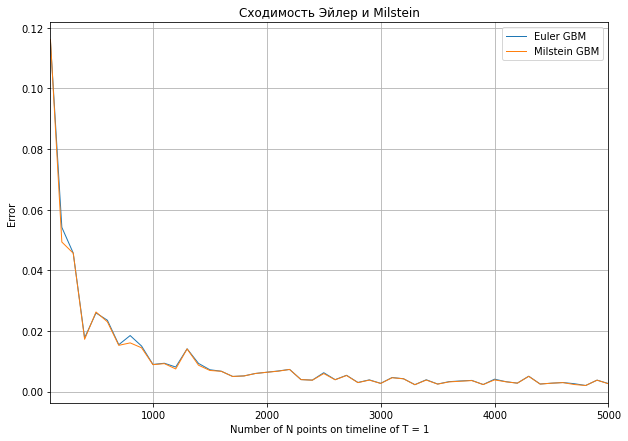

In [ ]:

g = [i for i in range(1, len(N)+1)]
plt.figure ( figsize =(10, 7) )
plt.grid ()

plt.plot (N, terrEU, linewidth =1.0, label="Euler GBM")
plt.plot (N, terrM, linewidth =1.0, label="Milstein GBM")


plt.title ("Сходимость Эйлер и Milstein")
plt.xlabel ("Number of N points on timeline of T = 1")
plt.ylabel ("Error")
plt.xlim(100, 5000)
plt.legend()
plt.show()

# **3) Генерация случайных значений**

In [ ]:
import pandas as pd

def ou_random_number_generator(x, theta1, theta2, theta3, t, delta_w, N):
  ou_mean = theta1 / theta2 + (x - theta1 / theta2) * np.exp(- theta2 * t)
  ou_variance = theta3**2 / (2 * theta2) * (1 - np.exp(- 2 * theta2 * t))
  return np.random.normal(ou_mean, ou_variance, 1)
  
def bsm_random_number_generator(x, theta1, theta2, delta, delta_w, N):
  bsm_lmean = np.log(x) + (theta1 - 1/2 * theta2**2) * delta
  bsm_lsd = np.sqrt(delta) * theta2
  return np.random.lognormal(bsm_lmean, bsm_lsd, 1)

def cir_random_number_generator(x, theta1, theta2, theta3, t, delta, delta_w, N):
  cir_mean = (theta1 / theta2) + (x - theta1 / theta2) * np.exp(-theta2 * t)
  cir_var = x * (theta3 ** 2) * (np.exp(-theta2 * t) - np.exp(-2 * theta2 * t)) / theta2 + (theta1 * theta3 ** 2) * (1 - np.exp(-2 * theta2 * t)) / (2 * theta2 ** 2) 
  return np.random.normal(cir_mean, cir_var)

x0 = 10
N = 100
T = 1

theta1 = 2
theta2 = 0.3
theta3 = 6

delta = T / N
z = np.random.normal(0, 1, N)
delta_w = z * np.sqrt(delta)

ou_random_numbers = []
bsm_random_numbers = []
cir_random_numbers = []
for t in range(1, N + 1):
  ou_random_numbers.append(ou_random_number_generator(x0, theta1, theta2, theta3, delta, delta_w, N))
  bsm_random_numbers.append(bsm_random_number_generator(x0, theta1, theta2, delta, delta_w, N))
  cir_random_numbers.append(cir_random_number_generator(x0, theta1, theta2, theta3, t, delta, delta_w, N))

d = {'ou_random_numbers': ou_random_numbers, 'bsm_random_numbers': bsm_random_numbers, 'cir_random_numbers': cir_random_numbers}
df = pd.DataFrame(d) 
df.to_csv('random_numbers.csv')

# **4) Генерация траекторий**

0.9-квантиль OU =  10.04673348918407


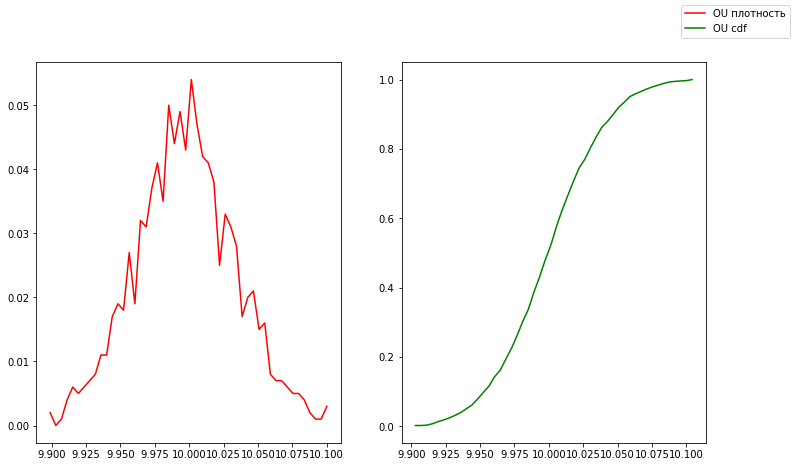

In [ ]:
#task 4

ou_count, ou_bins_count = np.histogram(ou_random_numbers, bins = 50)
ou_pdf = ou_count / sum(ou_count)
ou_cdf = np.cumsum(ou_pdf)

bsm_count, bsm_bins_count = np.histogram(bsm_random_numbers, bins = 50)
bsm_pdf = bsm_count / sum(bsm_count)
bsm_cdf = np.cumsum(bsm_pdf)

cir_count, cir_bins_count = np.histogram(cir_random_numbers, bins = 50)
cir_pdf = cir_count / sum(cir_count)
cir_cdf = np.cumsum(cir_pdf)

fig, axs = plt.subplots(1, 2, figsize=(12, 7))
axs[0].plot(ou_bins_count[:-1], ou_pdf, label="OU плотность", color = "red")
axs[1].plot(ou_bins_count[1:], ou_cdf, label="OU cdf", color = "green")
fig.legend()

fig.show()

print("0.9-квантиль OU = ", np.percentile(ou_random_numbers, 90))



0.9-квантиль BSM =  10.620108456209175


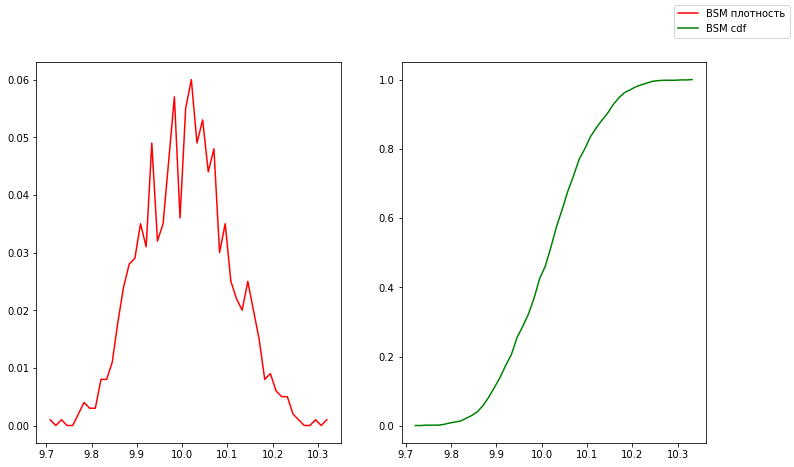

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7))
axs[0].plot(bsm_bins_count[:-1], bsm_pdf, label="BSM плотность", color = "red")
axs[1].plot(bsm_bins_count[1:], bsm_cdf, label="BSM cdf", color="green")
print("0.9-квантиль BSM = ", np.percentile(bsm_random_numbers, 90))


fig.legend()

fig.show()

In [ ]:
cir_random_numbers

[471.83872408933183,
 -771.8991131604157,
 -810.3466985097965,
 -118.59334154302105,
 -458.08012953294957,
 642.5487237117733,
 578.8719902933332,
 493.5853882507285,
 -320.59658185575495,
 -112.61587186497424,
 580.8241422746706,
 852.0628745068614,
 1049.346183821773,
 -178.64177071212046,
 -47.34442042763689,
 -362.5385582663448,
 256.5694951946059,
 210.14309866135608,
 116.0240456221844,
 -204.7076046375857,
 388.72208581194576,
 365.5829536552319,
 354.68194580088016,
 -1197.827204608972,
 517.4172296188142,
 -188.22899247130562,
 219.83620983475674,
 494.2943952886431,
 -98.13794327879417,
 -7.605468978127591,
 -243.6104478224764,
 -218.6375898306784,
 -22.384373833516037,
 -546.5109386272503,
 302.41583966137745,
 -583.6680423800912,
 55.51935059145141,
 139.94273945251643,
 601.2398025556847,
 -382.8122542797312,
 814.2916191727619,
 27.523670752652478,
 512.6850271734198,
 305.740515546451,
 480.17401107934916,
 479.00891935894833,
 -191.79431080031046,
 -937.4569548895614,
 

0.9-квантиль CIR =  518.3214827075576


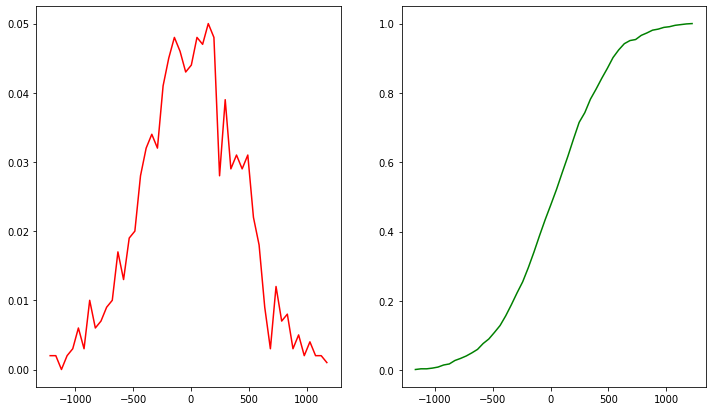

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7))
axs[0].plot(cir_bins_count[:-1], cir_pdf, label="CIR плотность", color = "red")
axs[1].plot(cir_bins_count[1:], cir_cdf, label="CIR cdf", color="green")

print("0.9-квантиль CIR = ", np.percentile(cir_random_numbers, 90))

# **5) Генерация траекторий для стационарных законов**

In [ ]:
def invariant_law_random_number_generator(theta1, theta2, theta3):
  il_mean = theta1 / theta2
  il_variance = theta3**2 / (2 * theta2)
  return np.random.normal(il_mean, il_variance, 1)

def stationary_law_random_number_generator(theta1, theta2, theta3):
  sl_shape = 2*theta1 / theta3**2
  sl_scale = theta3**2 / (2 * theta2)
  return np.random.gamma(sl_shape, sl_scale, 1)

il_random_numbers = []
sl_random_numbers = []

for t in range(1, N + 1):
  il_random_numbers.append(invariant_law_random_number_generator(theta1, theta2, theta3))
  sl_random_numbers.append(stationary_law_random_number_generator(theta1, theta2, theta3))

d = {'il_random_numbers': il_random_numbers, 'sl_random_numbers': sl_random_numbers}
df = pd.DataFrame(d) 
df.to_csv('random_numbers_for_stationary_laws.csv')

Invariant law 0.9-квантиль =  78.16233323650945


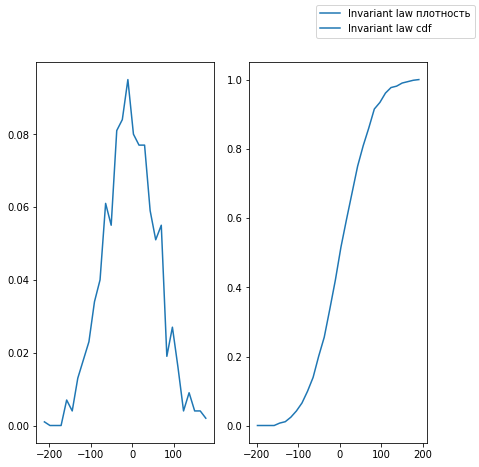

In [ ]:
il_count, il_bins_count = np.histogram(il_random_numbers, bins = 30)
il_pdf = il_count / sum(il_count)
il_cdf = np.cumsum(il_pdf)

sl_count, sl_bins_count = np.histogram(sl_random_numbers, bins = 30)
sl_pdf = sl_count / sum(sl_count)
sl_cdf = np.cumsum(sl_pdf)

fig, axs = plt.subplots(1, 2, figsize=(7, 7))
axs[0].plot(il_bins_count[:-1], il_pdf, label="Invariant law плотность")
axs[1].plot(il_bins_count[1:], il_cdf, label="Invariant law cdf")
fig.legend()
fig.show()

print("Invariant law 0.9-квантиль = ", np.percentile(il_random_numbers, 90))

Stationary law 0.9-квантиль =   16.96921802385805


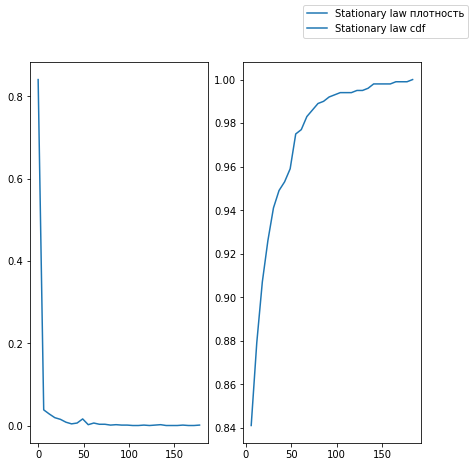

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
axs[0].plot(sl_bins_count[:-1], sl_pdf, label="Stationary law плотность")
axs[1].plot(sl_bins_count[1:], sl_cdf, label="Stationary law cdf")
print("Stationary law 0.9-квантиль =  ", np.percentile(sl_random_numbers, 90))
fig.legend()
fig.show()